<h3>1.  Read the dataset into a dataframe and explore</h3>
<p>Let's start by importing pandas and read the dataset into a DataFrame named df. Output the first 20 rows of the dataframe to get a general feel of how the data is structured.</p>

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("spam.csv", encoding='latin-1')
print(df.shape)
df.head(20)

(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


<h3>2. Clean the data</h3>
<p>We are only interested in words, clean the data so that all punctuations are removed. We should be left with a dataset that only contains alpha characters (including spaces). And should also ensure all the words are lowercase.</p>

In [ ]:
# drop NAN value columns
df = df.dropna(axis=1)

# change column headers
df.columns = ['Category', 'Message']

# lowercase
df['Message'] = df['Message'].str.lower()

# remove punctuations
df['Message'] = df['Message'].str.replace(r'[^A-Za-z\s]+', '', regex=True)

df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


<h3>3. Split the Data</h3>
<p>We split the data into two random samples, one for training the model and the other for testing the model. Create DataFrames named train_data and test_data. The train_data DataFrame should contain 75% of the data and the test_data DataFrame the remaining 25%.<p>

In [ ]:
# split data into 75:25 for training and test data sets
train_data = df.sample(frac = 0.75, random_state = 0)
test_data = df.drop(train_data.index)

train_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

train_data.head()

,Category,Message
0,ham,aight should i just plan to come up later tonight
1,ham,was the farm open
2,ham,i sent my scores to sophas and i had to do sec...
3,ham,was gr to see that message so when r u leaving...
4,ham,in that case i guess ill see you at campus lodge


<h3>4. Create a Word Frequency DataFrame</h3>
<p>We create a new DataFrame named word_freq that contains each word with the number of times it appears in a spam and a ham message.

In [ ]:
mask = train_data['Category'] == 'spam'

# split data using category
ham_data = train_data[~mask]['Message']
spam_data = train_data[mask]['Message']

# frequency of words
ham_data = ham_data.str.split(expand = True).stack().value_counts()
spam_data = spam_data.str.split(expand = True).stack().value_counts()

# merge series
word_freq = pd.concat([spam_data,ham_data], axis = 1).reset_index()

# remove nan values
word_freq = word_freq.fillna(0)

# rename columns
word_freq.columns = ['Word', '#Spam', '#Ham']

# float values to int
word_freq = word_freq.astype({'#Spam':'int', '#Ham':'int'})

word_freq[word_freq["#Spam"] == word_freq["#Ham"]]

,Word,#Spam,#Ham
337,months,6,6
346,charge,6,6
368,re,6,6
405,questions,5,5
425,log,5,5
...,...,...,...
1908,hp,1,1
1914,pole,1,1
1915,flirting,1,1
1916,bloke,1,1


<h3>5. Visualise the Data</h3>
<p>Let's use a Word Cloud library to visualise the most common words contained in spam messages.</p>



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS

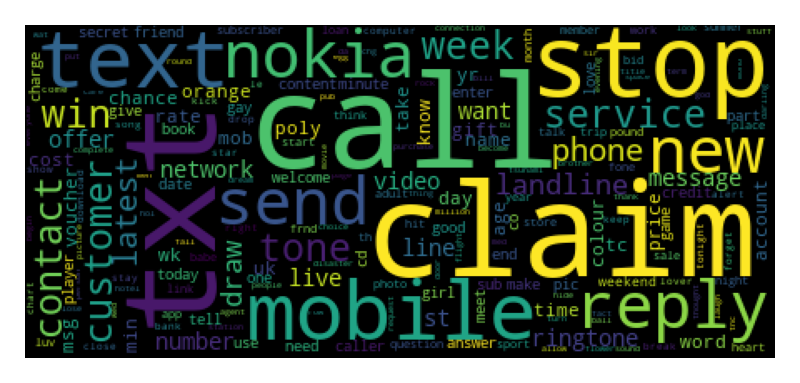

In [ ]:

cloud = WordCloud(width=450, height=200, colormap='viridis', background_color='black', stopwords=set(STOPWORDS))

# cloud from frequencies
# STOPWORDS are ignored if generating from frequencies
# scloud = cloud.generate_from_frequencies(dict(zip(word_freq['Word'], word_freq['#Spam'])))
scloud = cloud.generate(' '.join(word_freq['Word']))

plt.figure(figsize=(3,2), dpi=250, facecolor='white')
plt.imshow(scloud)
plt.axis('off')
plt.tight_layout(pad=0)

<h3>6.  Calculate $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$</h3>
<p>Next we create a new DataFrame named word_prob that gives the probability of each word being found in a spam and ham message.</p>
<p>To calculate the probability of a word being spam we divide the number of times the word was found in spam by the total number of spam messages, likewise to calculate the probability of each word being found in a ham message we divide the number of times the word was found in a ham message by the total number of ham messages.</p>
<p>If a word was not found in ham or spam it will cause problems later because the probability calculated will be zero. Therefore, we will use a pseudocount k and estimate the probability of seeing the word as smoothing.</p>

<p>$P\left(E\middle| S\right)$ = (number of spams containing the word + k) / (total number of spam messages + 2 * k).</p>
<p>Likewise, for $P\left(E|\lnot S\right)$.</p>

In [ ]:
k = 0.4
spam_count = word_freq['#Spam'].sum()
ham_count = word_freq['#Ham'].sum()

word_prob = word_freq.copy()
word_prob.columns = ['Word', 'P(E|S)', 'P(E|¬S)']

word_prob['P(E|S)'] = word_prob['P(E|S)'].apply(lambda word: (word+k)/(spam_count + 2 * k))
word_prob['P(E|¬S)'] = word_prob['P(E|¬S)'].apply(lambda word: (word+k)/(ham_count + 2 * k))

word_prob.head()


,Word,P(E|S),P(E|¬S)
0,to,0.043929,0.023455
1,a,0.023282,0.016333
2,call,0.021855,0.003589
3,you,0.018330,0.027076
4,your,0.017575,0.006210


<h3>7. Checking the 'spamliness' of a single word</h3>
<p>Now that we have trained the model, we will test the model.  Before we use the test_data, first let’s check how the model calculates the spamliness of a single word.  This is where we use the Bayes Theorem formula.  We have already calculated $P\left(E\middle| S\right)$ and $P\left(E|\lnot S\right)$, so we can just extract these values from the word_prob DataFrame.</p>
<p>We need to decide on the prior values $P\left(S\right)$ and $P\left(\lnot S\right)$, this is where we can experiment and tweak the model.
<h3>
$P\left(S\middle|\ E\right)=\frac{P\left(E\middle|\ S\right)P\left(S\right)}{P\left(E\middle|\ S\right)P\left(S\right)+P\left(E|\lnot S\right)P\left(\lnot S\right)}$
</h3>


In [ ]:
# set priors
prior_spam = 0.3
prior_ham = 0.7

# choose word
word = 'test'
mask = word_prob['Word'] == word

single_word_prob = word_prob.loc[mask]

prob_spam = (single_word_prob['P(E|S)'].item() * prior_spam)/ ((single_word_prob['P(E|S)'].item() * prior_spam) + ((single_word_prob['P(E|¬S)'].item() * prior_ham)))
prob_ham = (single_word_prob['P(E|¬S)'].item() * prior_ham)/ ((single_word_prob['P(E|S)'].item() * prior_spam) + ((single_word_prob['P(E|¬S)'].item() * prior_ham)))

# print
print(f"Word = ['{word}']")
print(f"P(E|S) = [{single_word_prob['P(E|S)'].item():0.8f}]")
print(f"P(E|¬S) = [{single_word_prob['P(E|¬S)'].item():0.8f}]")
print(f"P(S|E) = [{prob_spam:0.8f}]")
print(f"P(¬S|E) = [{prob_ham:0.8f}]\n")


# second test
word2 = 'blue'
mask = word_prob['Word'] == word2

single_word_prob = word_prob.loc[mask]

prob_spam = (single_word_prob['P(E|S)'].item() * prior_spam)/ ((single_word_prob['P(E|S)'].item() * prior_spam) + ((single_word_prob['P(E|¬S)'].item() * prior_ham)))
prob_ham = (single_word_prob['P(E|¬S)'].item() * prior_ham)/ ((single_word_prob['P(E|S)'].item() * prior_spam) + ((single_word_prob['P(E|¬S)'].item() * prior_ham)))

print(f"Word = ['{word2}']")
print(f"P(E|S) = [{single_word_prob['P(E|S)'].item():0.8f}]")
print(f"P(E|¬S) = [{single_word_prob['P(E|¬S)'].item():0.8f}]")
print(f"P(S|E) = [{prob_spam:0.8f}]")
print(f"P(¬S|E) = [{prob_ham:0.8f}]\n")

Word = ['test']
P(E|S) = [0.00003357]
P(E|¬S) = [0.00026808]
P(S|E) = [0.05093603]
P(¬S|E) = [0.94906397]

Word = ['blue']
P(E|S) = [0.00003357]
P(E|¬S) = [0.00020806]
P(S|E) = [0.06467879]
P(¬S|E) = [0.93532121]



<h3>8. Checking the 'spamliness' of several words</h3>
<p>To check the spamliness of several words contained in a message we multiply the probabilities.  The model assumes the words appear as independent events hence the naïve Bayes.  In reality of course, words are not independent events, but the model still performs well.  So we use the assumption that the words appear independently, and hence we multiply probabilities, so
$P(S\,|\, x_1,\dots,x_n)\approx \frac{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)}{P(S)\underset{i=1}{\overset{n}{\prod}}P(x_i | S)+P(\neg S)\underset{i=1}{\overset{n}{\prod}}P(x_i | \neg S)}$

We calculate the probability for each word in a message being spam. Then multiply the probabilities and compare the results. If the result of multiplying the probabilities for spam is greater than the result of multiplying the probabilities for not spam, then we assume the message as spam.

If we have a word in your message that is not in the word_prob DataFrame then we can't get the probability. Therefore, we will skip any words in the message that are not in the word_prob DataFrame.</p>

In [ ]:
import numpy as np

def check(arg):
    # priors
    prior_spam = 0.3
    prior_ham = 0.7
    
    # get unique words from message
    words = set(arg.split())
    
    word_spam = []
    word_ham = []

    for word in words:
        mask = word_prob['Word'] == word
        if word_prob[mask].empty or word in STOPWORDS:
            continue
        else:
            p_spam = word_prob.loc[mask]['P(E|S)'].item()
            p_ham = word_prob.loc[mask]['P(E|¬S)'].item()
            word_spam.append(p_spam)
            word_ham.append(p_ham)
    
    # Multiply all probabilities in list
    ham_prob = np.prod(word_ham)
    spam_prob = np.prod(word_spam)

    # Check spamliness of several words
    prob_spam = (prior_spam * spam_prob) / ((prior_spam * spam_prob) + (prior_ham * ham_prob))
    prob_ham = (prior_ham * ham_prob) / ((prior_spam * spam_prob) + (prior_ham * ham_prob))

    print(f"P(S|E) = [{prob_spam:0.8f}]")
    print(f"P(¬S|E) = [{prob_ham:0.8f}]")
    
    if prob_spam > prob_ham: print(f"The is message is most likely spam\n")
    else: print(f"The is message is most likely not spam\n")

    return prob_spam, prob_ham


message = "Hi I like french fries"

# Random text
_,_ = check(message)

# Check a ham message
_, _ = check(train_data.iloc[2]['Message'])

# Pass string
_, _ = check('Manchester is a big city')

# Check a spam message
_,_ = check(train_data.iloc[9]['Message'])


P(S|E) = [0.33936547]
P(¬S|E) = [0.66063453]
The is message is most likely not spam

P(S|E) = [0.00441793]
P(¬S|E) = [0.99558207]
The is message is most likely not spam

P(S|E) = [0.44694675]
P(¬S|E) = [0.55305325]
The is message is most likely not spam

P(S|E) = [0.91955373]
P(¬S|E) = [0.08044627]
The is message is most likely spam



<h3>9. Avoiding floating point underflow</h3>
<p>Our aim is to compare two probabilities $P(S|x_1,\dots,x_n)$ with $P(\neg S|x_1,\dots,x_n),$ according to our model introduced in Section 8, both probabilities share a common denominator which does not affect comparison. Hence we will calculate numerators only, which are proportional to $P(S|x_1,\dots,x_n)$ and $P(\neg S|x_1,\dots,x_n).$
</p>

<p>Multiplying a set of small probabilities could result in a floating-point error.  This is where the product becomes too small to be represented correctly.  To avoid this we can take the logarithm of the probabilities and add them.  

To avoid multiplication of small numbers, we use the following property of $\log(x):$</p>
$$
\log(a\cdot b)=\log(a)+\log(b)
$$


In [ ]:
def check_v2(arg):
    # priors
    prior_spam = 0.3
    prior_ham = 0.7
    
    # get unique words from message
    words = set(arg.split())
    
    word_spam = []
    word_ham = []

    for word in words:
        mask = word_prob['Word'] == word
        if word_prob[mask].empty or word in STOPWORDS:
            continue
        else:
            p_spam = word_prob.loc[mask]['P(E|S)'].item()
            p_ham = word_prob.loc[mask]['P(E|¬S)'].item()
            word_spam.append(p_spam)
            word_ham.append(p_ham)
    
    # Multiply all probabilities in list
    ham_prob = np.log10(word_ham).tolist()
    spam_prob = np.log10(word_spam).tolist()

    # Check spamliness of several words
    prob_spam = np.log10(prior_spam) + sum(spam_prob)
    prob_ham = np.log10(prior_ham) + sum(ham_prob)

    return prob_spam, prob_ham

def printxt(prob_spam,prob_ham):

    print(f"log(P(S|E)) = [{prob_spam:0.8f}]")
    print(f"log(P(¬S|E)) = [{prob_ham:0.8f}]")    
    if prob_spam > prob_ham: print(f"The is message is most likely spam\n")
    else: print(f"The is message is most likely not spam\n")

message = "Hi I like french fries"

# Random text
prob_spam, prob_ham = check_v2(message)
printxt(prob_spam,prob_ham)

# Check a ham message
prob_spam, prob_ham = check_v2(train_data.iloc[2]['Message'])
printxt(prob_spam,prob_ham)

# Pass random string
prob_spam, prob_ham = check_v2('There is a snake here')
printxt(prob_spam,prob_ham)

# Check a spam message
prob_spam, prob_ham = check_v2(train_data.iloc[9]['Message'])
printxt(prob_spam,prob_ham)

# More tests
prob_spam, prob_ham = check_v2(train_data.iloc[393]['Message'])
printxt(prob_spam,prob_ham)

prob_spam, prob_ham = check_v2(train_data.iloc[1719]['Message'])
printxt(prob_spam,prob_ham)

log(P(S|E)) = [-4.99690551]
log(P(¬S|E)) = [-4.70761188]
The is message is most likely not spam

log(P(S|E)) = [-76.91043049]
log(P(¬S|E)) = [-74.55757188]
The is message is most likely not spam

log(P(S|E)) = [-4.99690551]
log(P(¬S|E)) = [-4.32226100]
The is message is most likely not spam

log(P(S|E)) = [-7.60464494]
log(P(¬S|E)) = [-8.66271616]
The is message is most likely spam

log(P(S|E)) = [-12.74083906]
log(P(¬S|E)) = [-11.33799196]
The is message is most likely not spam

log(P(S|E)) = [-50.52536866]
log(P(¬S|E)) = [-42.85881190]
The is message is most likely not spam



<h3>10. Testing the Model</h3>
<p>Now that we have tested the model using simple messages.  Let’s test the model using the messages from the test_set. 

We should implement counters that displays how your model has performed and calculate the accuracy of the model.</p>


In [ ]:
match_spam = 0
match_ham = 0
thought_ham_is_spam = 0
thought_spam_is_ham = 0

for i in range(len(test_data)):
    prob_spam, prob_ham = check_v2(test_data.iloc[i]['Message'])
    category = test_data.iloc[i]['Category']
    if prob_spam > prob_ham:
        if category == 'spam':
            match_spam += 1
        else:
            thought_ham_is_spam += 1
    else:
        if category == 'ham':
            match_ham += 1
        else:
            thought_spam_is_ham += 1

accuracy = (match_spam + match_ham)/(match_spam + match_ham + thought_ham_is_spam + thought_spam_is_ham)

print(f"match_spam {match_spam}")
print(f"match_ham {match_ham}")
print(f"thougt_ham_is_spam {thought_ham_is_spam}")
print(f"thougt_spam_is_ham {thought_spam_is_ham}")
print(f"Accuracy: {accuracy}")


match_spam 174
match_ham 1165
thougt_ham_is_spam 45
thougt_spam_is_ham 9
Accuracy: 0.9612347451543432


<h3>11. Improvements</h3>

- One of the main suggestions to improve the accuracy of the model
would be re-train the model as new data is accumulated as training with a larger dataset would lead to better model generalization.

- We can tweak the prior values and filter out the highly frequent words which are in all classes before training to the maximize the accuracy of the model.

- Lastly, use some other classifier model which are available in **sklearn** in python to improve accuracy